課題  
- AIREC視点でforcemapの性能が出ない
- sim dataを用いたテストで使い物にならないくらい酷い予測結果
- 学習に用いたsim data（train）では高性能（epoch=1000で十分）．ただし，完全に過学習

タスクの発展  

0. basket, top view，object variation is small（IROS）
1. table, top view, object variation is large(T-RO)
2. table, side view, object variation is large(AIREC)



実験データ  
- object DB
- TR-O
    - 学習データ
        - tabletop240125（1000 scenes x 3 views = 3000 views）
        - objects: ycb_conveni_v1（ycbとconveniをmixして物品レベルで重複なく分割）
        - manual curation（おかしいデータを除外）
        - smoothed data：同じディレクトリ（force_zip?????.pkl）
    - 学習済モデル：20240304_1834_24/ForceEstimationResNetTabletop.pth
        - tracking data
        - ???
    - project data
         - ae_lstm_TRO.tgz (8GB)：実験に使っていた環境全部入り
        - git commit: ???
- AIREC 1st trial
    - 学習データ
        - tabletop_airec241008（1000 scenes x 3 views = 3000 views）
        - objects: ycb_conveni_v1
    - 学習済モデル：20241017_0052_35/08000.pth

確認実験（以前学習したモデル，sim data）  
- train/testで性能が出るか？train/testのlossはどれくらいか？（過学習状態？）
    - タスク2（以前学習したモデル20241017_0052_35）=> 上手く学習できていない
        - 08000.pth: train_loss=0.000167, test_loss=0.0226：綺麗に予測するには1e-4くらいのlossが必要．過学習
        - best.pth(epoch=27)：全然学習できておらず使えない
    - タスク1（以前学習したモデル20240304_1834_24）（同じデータ数で真上からのviewだと上手く学習できている）
        - <span style="color: red; ">epoch=31, train_loss=0.00477, test_loss=0.00679</span>

追試（もう一度，タスク１の学習を試す）
- 方法：train_tabletop_resnet.sh, ノートPCで試すためにbatch_size=8で学習
- 結果：明らかにlossの減り方が速い，過学習にならずに学習が進む．2024.03の学習結果とほぼ一致．（20250124_2000_19）
   - best.pth: <span style="color: red; ">epoch=76, train_loss=0.000267, test_loss=0.00641</span>
   - epoch=20でもtestについてはほとんど変わらない
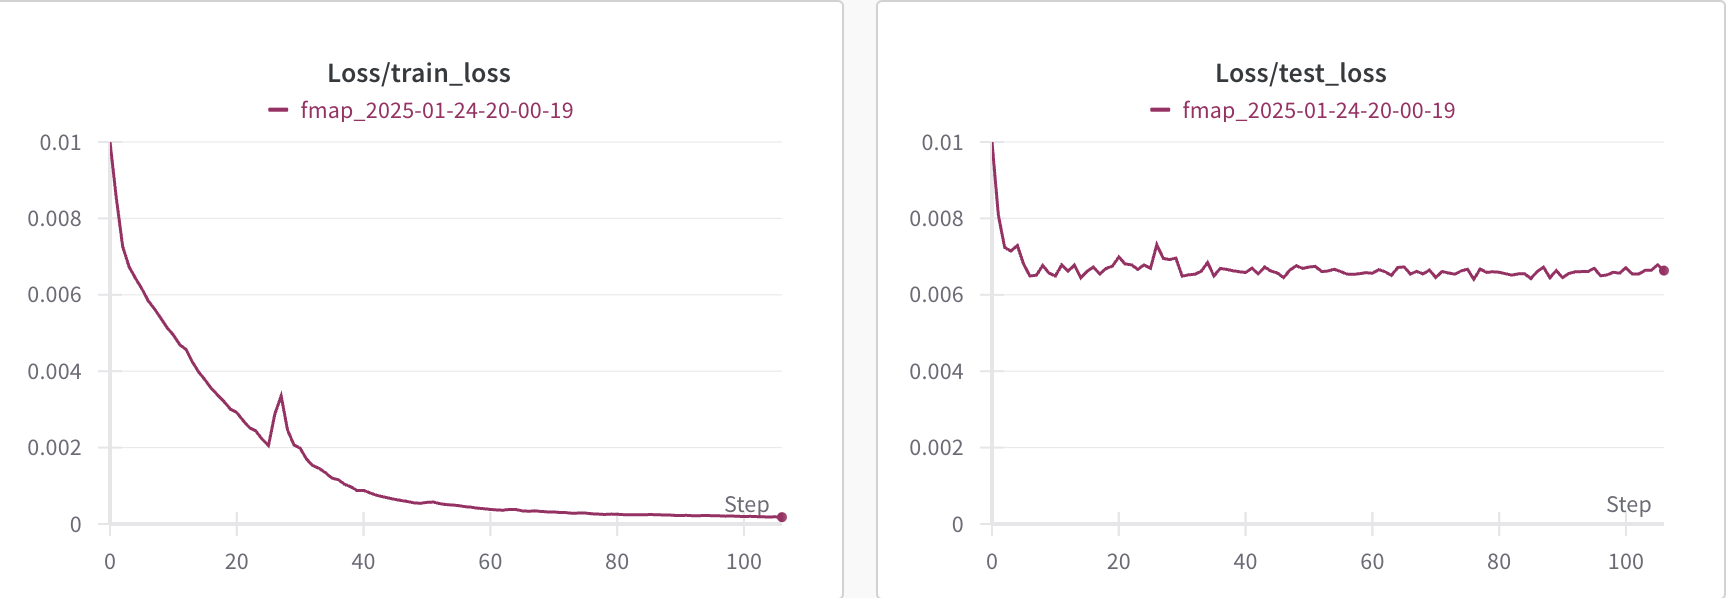

実験
- 仮説：ResNetで上手く学習できているtop-viewのデータに対してTransformerで学習をすると，性能は向上するか？
- 結果：lossはResNetの方が小さくなる．side viewに比べるとかなり小さくなる．（20250124_2054_23）
    - 予測結果は良さそう．ResNetより物体間の接触を上手く捉えられるかもしれない．（Transformerの効果か，depthの効果かは不明）
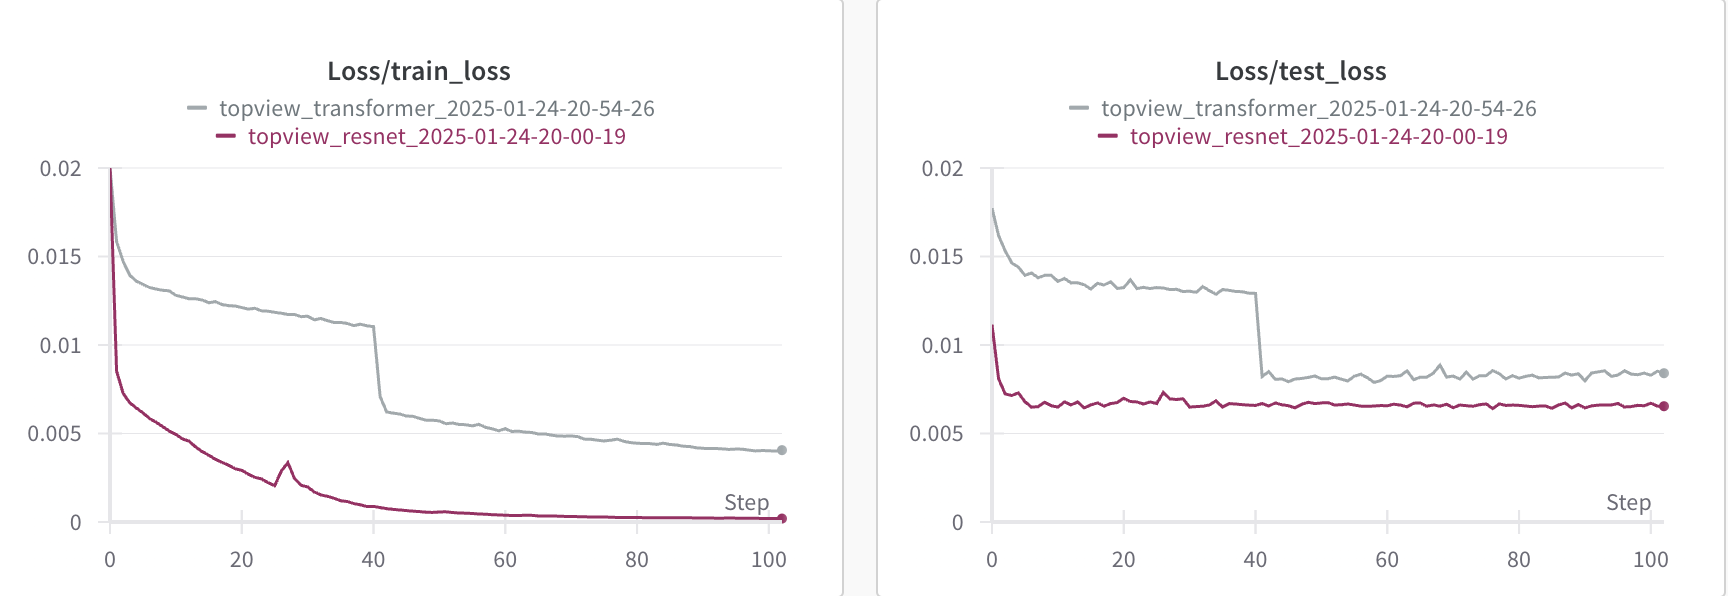
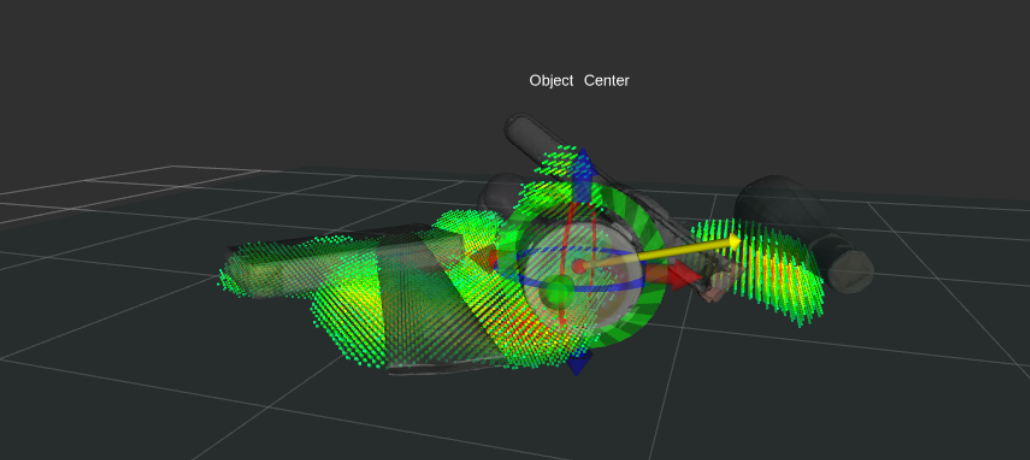
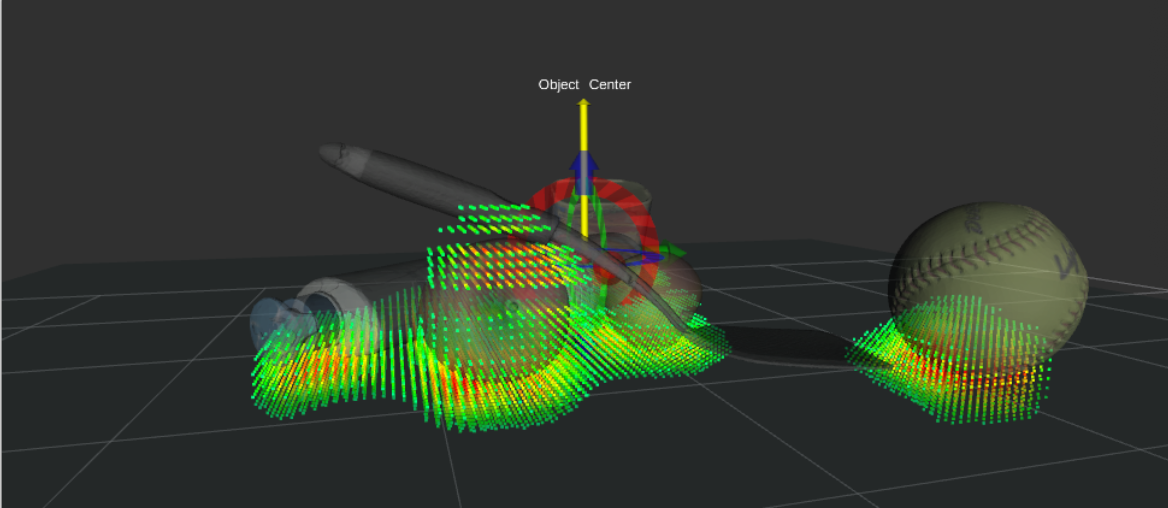


課題：なぜtop-viewでは上手く行かないか？

仮説
- smoothingを含むcuration処理の実装を変えたことが悪さをしている
- 視点をsideにすることでtask難易度が大幅に上がっている（見えのvariationが増えるから？透視変換の難しさ？）

データセット作成方法（2024.10月の研究ノートから）

- raw data作成（Isaac2022.2.0が必須）
<span style="color: green; ">
	- bugfix（simで接触点が非常に少なくなってしまった問題）
		- 23.1.1 => contact pointの多くでimpulse=0になっている．検出されているcontact pointsも少ないように見える．
		- Isaac4.2でも，Isaac2023.1.1でもget_contact_raw_dataが1つのcontact sensorに対して1つのcontact pointの情報しか返さない（おそらくバグ）
		- 以前の正しく動いていたcodeでも挙動は同じだった
		- Isaac2022.2.0 であれば正しく，複数のcontact情報を返す
		- 当面はこの環境を保存しつつ，最新Isaacで正しい値を取得する方法を探す（2024.10現在4.x系のIsaacしかダウンロードできなくなっている）
	- SDFの計算時間について
		- memory overflowでprogramが終了することはなくなったように見える
		- 速くなったのか？contact pointの評価時間がかなりのbottle neckになっている
</span>
```sh
$ ~/.local/share/ov/pkg/isaac_sim-2022.2.0/python.sh forcemap_isaac_AIREC.py -- --method sim --num_scenes 50
```
- smoothing
```sh
$ conda activate densefusion
$ ipython forcemap_isaac_AIREC.py -- --method smoothing
```


実験：1000シーンのデータを追加


- 今後
	- データ追加でいくらか改良が見られれば，さらに追加することも検討（
    - top viewとside viewを両方保存，（できればforce vectorとdepthも保存）
	- 同じforceをtop viewから予測する場合とside viewから予測する場合を比較する
	- 実装
		- ハイパラ管理
		- smoothingの高速化

seedを変えて分散をグラフにする（data量よりseedの方が影響が大きい可能性がある）
transformerはlrを下げた方が良いかもしれない

lossをKL(p,q) -> 徐々にKL(q,p)を大きくする：KLは確率分布（総和=1）でないと上手く機能しない
Vit encoderもfine-tuneする